# Simulate proteome time profiles.
## Start from measured proteome that is already hedged: necessary to enable lactate usage later?

In [1]:
import seaborn as sns
import pandas as pd

sns.plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.float_format', lambda x: '%.3g' % x)
%matplotlib inline

In [2]:
PROTOTYPE = False

In [3]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

In [4]:
cplx_concs_max = get_cplx_concs(solver)

In [5]:
mu_me = me.solution.x_dict['biomass_dilution']
print 'mu of ME for growth maximization:', mu_me

mu of ME for growth maximization: 0.911689453125


In [6]:
from dynamicme.dynamic import DelayedDynamicME

dyme = DelayedDynamicME(solver)
dyme.delay_model.solver.set_realopts('lp', {'Feasibility tol':1e-15,'Optimality tol':1e-15})
dsolver = dyme.delay_model.solver

## Initial condition proteome
1. Optimal predicted proteome on glucose (unrealistic--useful for illustrating difference from actual generalist observed)
1. Measured proteome on glucose (more realistic--generalist)

**A result in itself?:** explaining and predicting differences in growth trajectories depending on initial proteome
- explains why passing a few generations allows adaptation without mutation enabling faster growth of even the wild-type
- also means initial proteome definitely not at growth optimal--can show the difference
- does this mechanism also explain lag phase?

### Need to show results for multiple initial representative proteomes
1. Glucose optimal
1. Glycerol optimal (since glycerol wasn't fully utilized)
1. Measured glucose proteome--at fixed measured growth rate and closest proteome

# Initial proteome A: closest to measured proteome at measured growth rate
## Test the optimal predicted proteome

In [7]:
C_meas = 'Glucose'
###
df_meta = pd.read_csv('/home/laurence/ME/data/cobrame/sectors/proteomics_conds.csv')
mu_meas = df_meta[ df_meta.exp==C_meas].iloc[0]['Growth.rate..h.1.']
print 'Growth on %s = %g' % (C_meas, mu_meas)

Growth on Glucose = 0.58


In [8]:
df_meas = pd.read_csv('/home/laurence/ME/data/cobrame/sectors/schmidt_prot_mf.csv')
print df_meas.shape
#df_meas.head(2)

(51898, 8)


In [9]:
df_meas_C = df_meas[ df_meas.condition==C_meas]
#df_meas_C.head(2)

In [10]:
meas_dict = {r['Bnumber']:r['mf'] for i,r in df_meas_C.iterrows()}

In [11]:
sum(meas_dict.values())

0.9999999999999964

# Get simulated proteome closest to measured
- L1 (drops potential outliers)
- L2 (tries to get match everything)
    - should pre-process to remove outliers?

In [12]:
%%time

from cobrawe.fit import FitME

fit = FitME(me)
#me_nlp = fit.me_nlp
#me_nlp.compiled_expressions = None
#sol,stat,hs = fit.fit_mass_frac(meas_dict, mu_meas, norm='l1')

CPU times: user 56.7 ms, sys: 20 ms, total: 76.7 ms
Wall time: 75.5 ms


## Initialize dynamicME with this feasible initial proteome and growth rate

In [14]:
cplx_concs = get_cplx_concs(solver)
cplx_conc_dict0 = dict(cplx_concs)

In [15]:
import json

# fname = '/home/laurence/ME/data/dynamicME/production/cplx_conc_opt_%s.csv'%C_meas
# print fname
# with open(fname,'w') as f:
#     json.dump(cplx_conc_dict0, f)

# Validate mixed substrate uptake hierarchy--Beg et al. (2007) MSB

In [16]:
import warnings

T = 10   # hours
V = 1.   # L
X0 = 0.00675 / V  # g/L
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}

### Convert from g/L to mmol
mids_remove = []
for mid,c in c0_dict.iteritems():
    try:        
        met = me.metabolites.get_by_id(mid)    
        c0_dict[met.id] = c / met.formula_weight * 1000
    except KeyError:
        warnings.warn('Model has no metabolite: %s. Will remove it from c0_dict' % mid)
        mids_remove.append(mid)

for mid in mids_remove:
    c0_dict.pop(mid)
        
### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():
    try:
        rxn = dyme.get_exchange_rxn(mid)    
        if rxn.id is 'EX_o2_e':
            lb = LB_O2
        else:
            lb = LB_EX
        rxn.lower_bound = lb
        lb_dict[rxn.id] = lb
    except KeyError:
        warnings.warn('Model has no metabolite: '+ mid)

me.reactions.EX_o2_e.lower_bound = -20.
lb_dict[me.reactions.EX_o2_e.id] = -20.
        
print c0_dict
print lb_dict

{'glyc_e': 4.34339676647141, 'malt_e': 1.1685776026677226, 'lac__L_e': 4.4908498933423155, 'gal_e': 2.220299442904667, 'ac_e': 0.0, 'glc__D_e': 2.220299442904667}
{u'EX_glyc_e': -10.0, u'EX_o2_e': -20.0, u'EX_gal_e': -10.0, u'EX_lac__L_e': -10.0, u'EX_malt_e': -10.0, u'EX_ac_e': -10.0, 'EX_glc__D_e': -10.0}


In [17]:
import numpy as np
cvals = np.array(cplx_conc_dict0.values())
cvals[ cvals>0].min()

3.5212385356286455e-14

In [18]:
dyme = DelayedDynamicME(solver)

In [19]:
solver.set_realopts('lp', {'Feasibility tol':1e-15, 'Optimality tol':1e-15})

In [20]:
from cobrame import MetabolicReaction

if PROTOTYPE:
    fluxes_plot = ['ACONTa_CPLX0-7760_mod_4fe4s', 'ACONTb_CPLX0-7760_mod_4fe4s', 'ACKr_reverse']
else:
    #fluxes_plot = [r.id for r in dsolver.me.reactions if isinstance(r,MetabolicReaction)]
    fluxes_plot = [r.id for r in dsolver.me.reactions]

In [21]:
len(fluxes_plot)

15565

In [ ]:
%%time
extra_rxns_tracked = list(set(['EX_o2_e'] + fluxes_plot + ['biomass_dilution']))

T = 20
dt = 0.5
H = dt

result = dyme.simulate_batch(
    T,    
    c0_dict,
    X0,
    prec_bs=1e-3,
    ZERO_CONC=0.,
    extra_rxns_tracked=extra_rxns_tracked,
    lb_dict={},
    verbosity=2,
    dt = dt,
    H = H,
    cplx_conc_dict0=cplx_conc_dict0)

Metabolite glyc_e available.
Using default LB=-1000 for EX_glyc_e
Metabolite ac_e depleted.


### Save results

In [35]:
import json
result2 = result.copy()
result2.keys()
result2.pop('basis')

with open('/home/laurence/ME/data/dynamicME/production/validation1_uptake_hier_sim_opt0.json','w') as f:
    json.dump(result2, f)

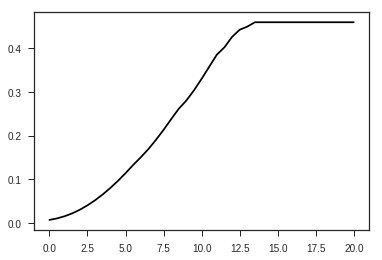

In [36]:
import seaborn as sns
%matplotlib inline

sns.plt.plot(result['time'], result['biomass'])

In [37]:
ex_met_rxn_dict = {m: {'rxn':dyme.get_exchange_rxn(m), 'mw':me.metabolites.get_by_id(m).formula_weight} for m in c0_dict.keys()}
ex_met_rxn_dict

{'ac_e': {'mw': 59.04402, 'rxn': <Reaction EX_ac_e at 0x7fbbae600f90>},
 'gal_e': {'mw': 180.15588, 'rxn': <Reaction EX_gal_e at 0x7fbbae6d3950>},
 'glc__D_e': {'mw': 180.15588,
  'rxn': <Reaction EX_glc__D_e at 0x7fbbae6bf990>},
 'glyc_e': {'mw': 92.09382, 'rxn': <Reaction EX_glyc_e at 0x7fbbae6b1310>},
 'lac__L_e': {'mw': 89.07, 'rxn': <Reaction EX_lac__L_e at 0x7fbbae6fff10>},
 'malt_e': {'mw': 342.29648, 'rxn': <Reaction EX_malt_e at 0x7fbbae6f1cd0>}}

In [38]:
import pandas as pd

df_conc = pd.DataFrame(result['concentration'])
### Convert concentrations to g/L
for mid, vals in ex_met_rxn_dict.iteritems():
    df_conc[mid] = df_conc[mid] * vals['mw'] * 0.001

df_time = pd.DataFrame({'time':t, 'biomass':b} for t,b in zip(result['time'], result['biomass']))
df_flux = pd.DataFrame(result['ex_flux'])
df_mu   = pd.DataFrame({'mu':result['growth_rate']})
df_result = pd.concat([df_time, df_conc, df_flux, df_mu], axis=1)

In [39]:
dsplot = pd.melt(df_result, id_vars='time', value_vars=['biomass','ac_e','gal_e','glc__D_e','glyc_e','lac__L_e','malt_e'])
dsplot.time = pd.to_numeric(dsplot.time)
dsplot['category'] = 'Metabolite'
dsplot.loc[ dsplot.variable=='biomass', 'category'] = 'Biomass'

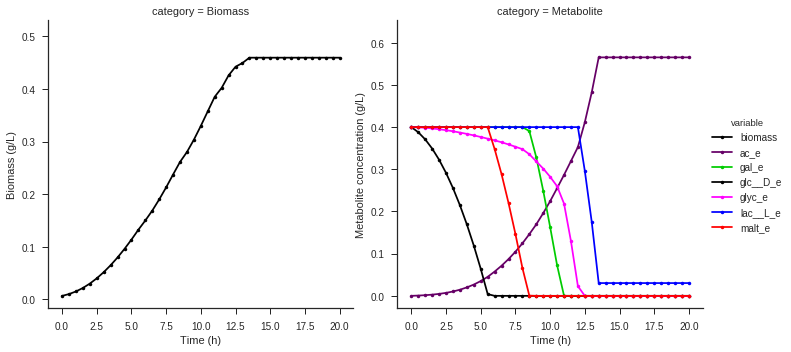

In [81]:
colors = [
'#000000', # biomass
'#660066', # acetate
'#00CC00', #'#00FF00', # galactose
'#000000', # glucose
'#FF00FF', # glycerol
'#0000FF', # lactate
'#FF0000', # maltose
]

colpal = sns.color_palette(colors)
sns.set_palette(colpal)

g = sns.FacetGrid(data=dsplot, hue='variable', col='category', sharey=False, size=5)

g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
for i,ax in enumerate(g.axes.flat):
    ylim = ax.get_ylim()
    ax.set_ylim((ylim[0],ylim[1]*1.1))
    if i==0:
        ax.set_ylabel('Biomass (g/L)')
    else:
        ax.set_ylabel('Metabolite concentration (g/L)')
g.set_xlabels('Time (h)')
g.add_legend()

In [82]:
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt.pdf')
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt.svg')
g.savefig('/home/laurence/ME/figures/persistME/beg_init_opt.eps')

In [41]:
if PROTOTYPE:
    complexes_plot = ['IPPMIa_E_c', 'ACKr_reverse_E_c', 'CPLX0-7760_mod_4fe4s','CPLX0-7761_mod_4fe4s']
else:
    complexes_plot = ['3-ISOPROPYLMALISOM-CPLX_mod_4fe4s', 'ACETATEKINA-MONOMER_mod_mg2', 'CPLX0-7659']

In [42]:
fluxes_plot2 = []

for rid in fluxes_plot:
    rxn = dsolver.me.reactions.get_by_id(rid)
    try:
        if abs(rxn.x) > 20:
            fluxes_plot2.append(rxn.id)
    except:
        pass
        
print len(fluxes_plot2)

6


In [43]:
df_mu = pd.DataFrame([{'time':t, 'variable':'growth_rate', 'value':c, 'category':'growth'} for t,c in zip(result['time'], result['growth_rate'])] )

df_complex = pd.DataFrame([{'time':t, 'complex':c, 'abundance':cdict[c]} 
                           for t,cdict in zip(result['time'], result['complex']) for c in complexes_plot] )

df_mflux = pd.DataFrame([{'time':t, 'rxn':c, 'flux':cdict[c]} 
                           for t,cdict in zip(result['time'], result['rxn_flux']) for c in fluxes_plot2] )

df_complex.loc[:,'category'] = 'complex'
df_mflux.loc[:,'category'] = 'flux'

dsplot_all = pd.concat([dsplot,
                        df_mu,
                          df_complex.rename(columns={'complex':'variable', 'abundance':'value'}),
                          df_mflux.rename(columns={'rxn':'variable', 'flux':'value'})])

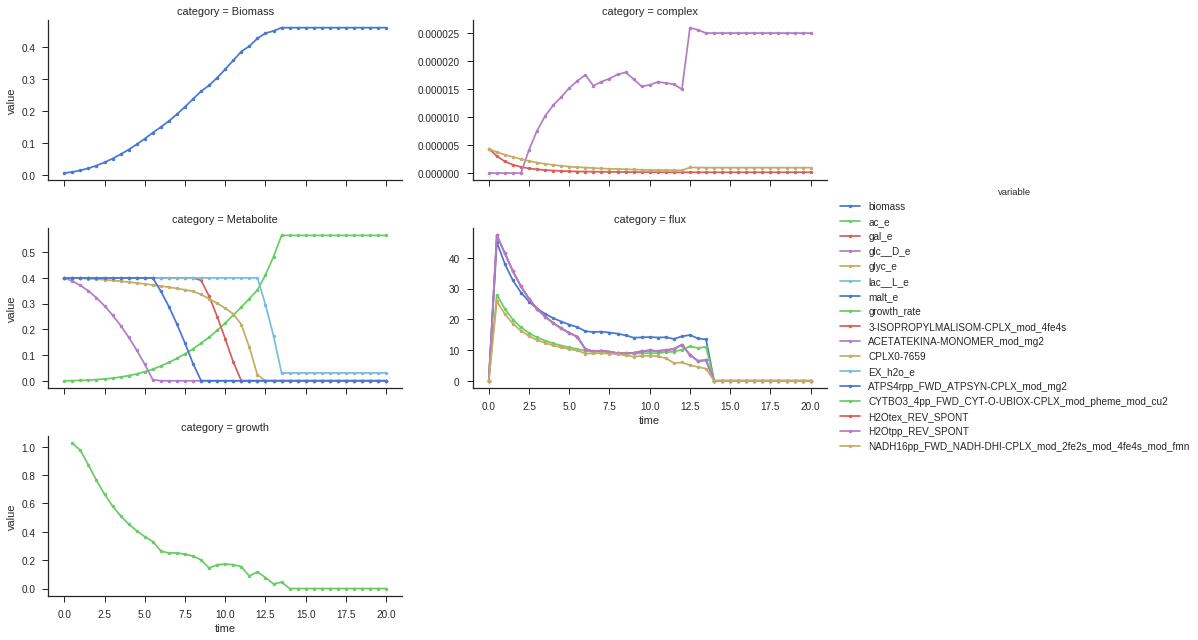

In [44]:
sns.set_style('ticks')
palette = sns.color_palette('muted', len(dsplot_all.variable.unique()))
g = sns.FacetGrid(data=dsplot_all, hue='variable', sharey=False, size=3, col='category', palette=palette,
                  aspect=2, col_wrap=2, col_order=['Biomass','complex','Metabolite','flux','growth'])
g.map(sns.plt.plot, 'time', 'value', linestyle='-', marker='.')
g.add_legend()

### In general, it seems virtual cell lacks capacity to replenish the continuously diluting proteome.
### Actually, not entirely true--see very rapid rise in ACK protein. But is that because it's cheaper (recall Hwa's overflow mechanism--ATP per protein cost)
### Need to start it off with much more ribosome?

## Proteome mol (mass) fractions

In [85]:
#df_super = pd.read_csv('/home/laurence/ME/data/cobrame/proteome_letter/subsystem-supersystem-mapping.csv')
df_system = pd.read_csv('/home/laurence/ME/data/cobrame/proteome_letter/sub_supersystem.csv')
df_system.shape

# df_trsl = pd.DataFrame([{'rxn':k, 'v':v, 'time':result['time'][i]} for i,r in enumerate(result['rxn_flux']) for k,v in r.iteritems() if 'translation_' in k])

import re
patt = re.compile(r"protein_(b\d\d\d\d)_?\S?")

cplx_prot = pd.DataFrame([{'cplx':d.id, 'locus':re.findall(patt,k)[0]} for d in me.complex_data for k,v in d.stoichiometry.iteritems() if 'protein_b' in k])

df_mass = pd.DataFrame([{'cplx':met.id, 'mass':met.mass} for met in me.metabolites if hasattr(met,'mass')])
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])
df_cplx_mass = pd.merge(df_cplx, df_mass, on='cplx')

times = df_cplx_mass.time.unique()
for t in times:
    dfi = df_cplx_mass[ df_cplx_mass.time==t]
    masses = dfi.conc*dfi.mass
    mtot = masses.sum()
    mfs = masses/mtot
    b = (df_cplx_mass.time==t).values
    df_cplx_mass.loc[b,'mf'] = mfs

df_cplx_mass = pd.merge(df_cplx_mass, cplx_prot, on='cplx', how='left')

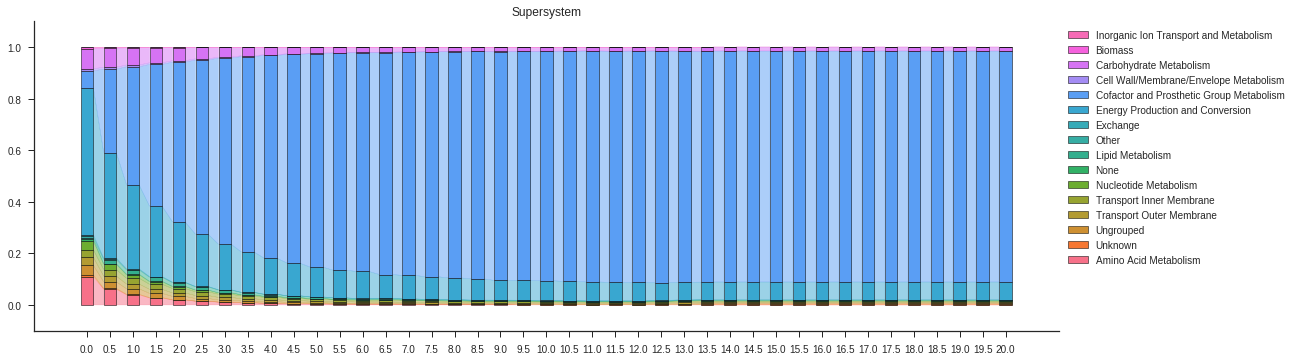

In [86]:
#syslevel = 'Subsystem'
syslevel = 'Supersystem'

df_level = df_system[['gene',syslevel]].drop_duplicates()

df_cplx_sub = pd.merge(df_cplx_mass, df_level, left_on='locus', right_on='gene', how='left')
df_cplx_sub.loc[ df_cplx_sub[syslevel].isnull(), syslevel] = 'Ungrouped'

df_mf_sector = df_cplx_sub.groupby(['time',syslevel]).mf.sum().reset_index()
# Renormalize to 1
dsplot_sector = df_mf_sector.copy()
for t in dsplot_sector.time.unique():
    b = dsplot_sector.time==t
    mtot = sum(dsplot_sector.loc[b,'mf'])
    dsplot_sector.loc[b, 'mf'] = dsplot_sector.loc[b, 'mf']/mtot

from stressme.plot import stacked_bar

dsplot_sector.loc[:,'group'] = syslevel
g = stacked_bar('time', 'mf', dsplot_sector, syslevel, 'group', size=5, aspect=3)

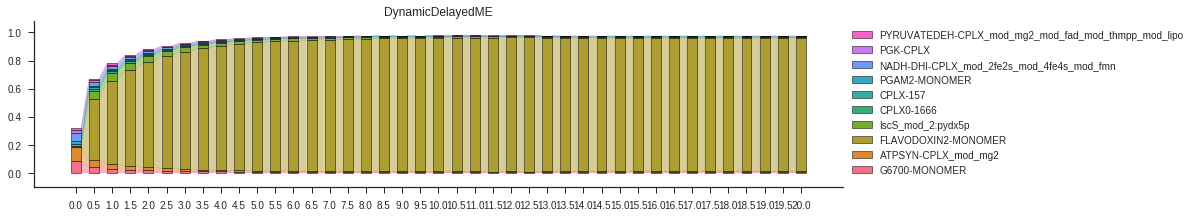

In [84]:
df_mass = pd.DataFrame([{'cplx':met.id, 'mass':met.mass} for met in me.metabolites if hasattr(met,'mass')])
df_cplx = pd.DataFrame([{'cplx':k, 'conc':v, 'time':result['time'][i]} for i,r in enumerate(result['complex']) for k,v in r.iteritems()])
df_cplx_mass = pd.merge(df_cplx, df_mass, on='cplx')

times = df_cplx_mass.time.unique()
for t in times:
    dfi = df_cplx_mass[ df_cplx_mass.time==t]
    masses = dfi.conc*dfi.mass
    mtot = masses.sum()
    mfs = masses/mtot
    b = (df_cplx_mass.time==t).values
    df_cplx_mass.loc[b,'mf'] = mfs

#df_var = df_cplx_mass.groupby('cplx').mf.var().reset_index()
df_var = df_cplx_mass.groupby('cplx').mf.mean().reset_index()
N_PLOT = 10
vary_cplxs = df_var.sort_values('mf', ascending=False)['cplx'][0:N_PLOT].values
vary_cplxs

df_cplx_mass[ df_cplx_mass.time==0].mf.sum()

from stressme.plot import stacked_bar

dsplot_cplx = df_cplx_mass[ df_cplx_mass.cplx.isin(vary_cplxs)]
dsplot_cplx.loc[:,'group'] = 'DynamicDelayedME'
stacked_bar('time', 'mf', dsplot_cplx, 'cplx', 'group', aspect=4)